# Prep 

In [1]:
#imports
%load_ext autoreload
%autoreload 2
%matplotlib inline

import os
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import xarray as xr

from scipy.signal import filtfilt,convolve
from scipy.linalg import lstsq, solve
from scipy.sparse.linalg import LinearOperator, cg, lsqr
from scipy import misc

from pylops.utils                      import dottest
from pylops.utils.wavelets             import *
from pylops.utils.tapers               import *
from pylops.utils.signalprocessing     import convmtx
from pylops.basicoperators             import *
from pylops.signalprocessing import *
from pylops.waveeqprocessing.wavedecomposition import *
from pylops.waveeqprocessing.oneway import PhaseShift
from pylops.waveeqprocessing.mdd import MDC, MDD
# from pylops.optimization.solver  import cgls
from time import time
from copy import deepcopy as dc
from scipy.sparse.linalg import LinearOperator

In [3]:
# import sys
# sys.path.insert(0,'../mpi_examples/')
# from usv import *

In [6]:
#set up constants
jtdata = 2 # shift to apply to the Mck pup
jt = 0 # shift to apply to R to allow alignment with Rest (obsolete)
ivs = 75 # virtual source to use for visualization

niter = 20 # MDD iterations

#load data
ds_mko = xr.open_dataset('../data/ds2/S_mko.nc')
# print("S-MKO REDATUMED WAVEFIELDS: {}".format(ds_mko.keys()))

# FD Local reflection response @ z=4400m, f_max -> 40Hz - axes, attrs included
ds_R = xr.open_dataset('../data/ds2/R_FD_40Hz_z4400.nc')
# print("R FINITE DIFFERENCES 60Hz : {}".format(ds_R.keys()))

# Receivers
r = ds_mko.coords['x_vs'].values
nr = r.size
dr = r[1]-r[0]

# Sources
s = ds_mko.coords['x_r'].values
ns = s.size
ds = s[1]-s[0]

# Time
t = ds_mko.coords['t'].values
nt = t.size
dt = t[1]-t[0]

# Wavelet
wav, _, wav_c = ricker(t[0:51], 20)
wav_c = np.argmax(wav)

# Data (rescale to get values around 1)
pdown = ds_mko['g_plus'].values * 2000
pup = ds_mko['g_minus'].values * 2000

# pup.max(), pdown.max()

# Pad data with zero at the end (to avoid wrap around)
npad = 5
pdown = np.pad(pdown, ((0, npad), (0, 0), (0, 0)))

pup = np.pad(pup, ((0, npad+jtdata), (0, 0), (0, 0))) 
pup = pup[jtdata:]

Rorig = ds_R['R'].values
Rorig = np.pad(Rorig, ((0, npad), (0, 0), (0, 0)))

ntpad = pdown.shape[0]
tpad = np.arange(ntpad) * dt


# As R is currently q->vz, transform it into q->q
tracelim = (1e7, -1e7)

rho_sep = 2000
vel_sep = 2766.85
nfftf = ntpad
nfftk = nr
PtoVop = PressureToVelocity(ntpad, nr, dt, dr,
                            rho_sep, vel_sep,
                            nffts=(nfftk, nfftf),
                            critical=100., ntaper=11,
                            topressure=True)           

R = np.hstack([PtoVop * Rorig[:, ir].T.ravel() for ir in range(nr)])
R = np.real(R.reshape(nr, nr, ntpad)).transpose(2, 0, 1)
R = (R + R.transpose(0, 2, 1)) / 2 # enforce reciprocity


# Convert to frequency and define fmax
nfmax = 400
nfft = ntpad
FFTop = FFT2D(dims=[nr, ntpad], nffts=[nr, nfft], sampling=[dr, dt])
PUP = (FFTop*pup[:, ns//2].T.flatten()).reshape(nr, nfft)
PDOWN = (FFTop*pdown[:, ns//2].T.flatten()).reshape(nr, nfft)

# Filter out high freqs from true response
RTRUE = np.concatenate([(FFTop * R[:, ir].T.ravel()).reshape(1, nr, nfft) for ir in range(nr)], axis=0)
RFILT = RTRUE.copy()
RFILT[:, :, nfmax:-nfmax] = 0
Rfilt = np.concatenate([np.real((FFTop.H * RFILT[ir].ravel()).reshape(1, nr, ntpad)) for ir in range(nr)], axis=0).transpose(2, 0, 1)


# Convert downgoing data to velocity
rho_sep = 2000
vel_sep = 2766.85
nfftf = ntpad
nfftk = nr
PtoVop = PressureToVelocity(ntpad, nr, dt, dr,
                            rho_sep, vel_sep,
                            nffts=(nfftk, nfftf),
                            critical=100., ntaper=11,
                            topressure=False)           

vzdown = np.hstack([PtoVop * pdown[:, isrc].T.ravel() for isrc in range(ns)])
vzdown = np.real(vzdown.reshape(ns, nr, ntpad)).transpose(2, 0, 1)
vzdown *= 1e7

In [7]:
#ops
def ops(nt, nv, ns, nr):
    from pylops import Identity
    from pylops.signalprocessing import FFT

    nfft = int(np.ceil((nt + 1) / 2))
    Iop = Identity(N=nfmax * nr * nv, M=nfft * nr * nv, inplace=True, dtype='float64')
    I1op = Identity(N=nfmax * ns * nv, M=nfft * ns * nv, inplace=True, dtype='float64')
    I1opH = I1op.H

    Fop = FFT(dims=(nt, nr, nv), dir=0, real=True, ifftshift_before=twosided, engine = 'numpy')
    F1op = FFT(dims=(nt, ns, nv),dir=0,real=True, ifftshift_before=False, engine = 'numpy')
    F1opH = F1op.H
    Iop_com = Identity(N=nfmax * nr * nv, M=nfft * nr * nv, inplace=True, dtype=complex)
    I1op_com = Identity(N=nfmax * ns * nv, M=nfft * ns * nv, inplace=True, dtype=complex)
    I1opH_com = I1op_com.H
    return Iop_com, Fop, I1opH_com, F1opH

# Fredholm
import numpy as np

from pylops import LinearOperator
from pylops.utils.backend import get_array_module
class Fredholm1(LinearOperator):
    def __init__(self, G, nz=1, saveGt=True, usematmul=True, dtype="float64"):
        self.nz = nz
        self.nsl, self.nx, self.ny = G.shape
        self.G = G
        if saveGt:
            self.GT = G.transpose((0, 2, 1)).conj()
        self.usematmul = usematmul
        self.shape = (self.nsl * self.nx * self.nz, self.nsl * self.ny * self.nz)
        self.dtype = np.dtype(dtype)
        self.explicit = False
    def _matvec(self, x):
        ncp = get_array_module(x)
#         x = ncp.squeeze(x.reshape(self.nsl, self.ny, self.nz))
        x = x.reshape(self.nsl, self.ny, self.nz)
        if self.usematmul:
            if self.nz == 1:
                x = x[..., ncp.newaxis]
            y = ncp.matmul(self.G, x)
        else:
#             y = ncp.squeeze(ncp.zeros((self.nsl, self.nx, self.nz), dtype=self.dtype))
            y = ncp.zeros((self.nsl, self.nx, self.nz), dtype=self.dtype)
            for isl in range(self.nsl):
                y[isl] = ncp.dot(self.G[isl], x[isl])
        return y.ravel()
    def _rmatvec(self, x):
        ncp = get_array_module(x)
#         x = ncp.squeeze(x.reshape(self.nsl, self.nx, self.nz))
        x = x.reshape(self.nsl, self.nx, self.nz)
#         print (f'rhs.shape: {x.shape}')
        if self.usematmul:
            if self.nz == 1:
                x = x[..., ncp.newaxis]
            if hasattr(self, "GT"):
                y = ncp.matmul(self.GT, x)
            else:
                # y = ncp.matmul(self.G.transpose((0, 2, 1)).conj(), x)
                y = (
                    ncp.matmul(x.transpose(0, 2, 1).conj(), self.G)
                    .transpose(0, 2, 1)
                    .conj()
                )
        else:
#             y = ncp.squeeze(ncp.zeros((self.nsl, self.ny, self.nz), dtype=self.dtype))
            y = ncp.zeros((self.nsl, self.ny, self.nz), dtype=self.dtype)
#             print (f'ans.shape: {y.shape}')
            if hasattr(self, "GT"):
                if 0: #self.nsl == 1:
                    y = ncp.dot(self.GT[0], x)
                else:
                    for isl in range(self.nsl):
                        y[isl] = ncp.dot(self.GT[isl], x[isl])
            else:
                for isl in range(self.nsl):
                    # y[isl] = ncp.dot(self.G[isl].conj().T, x[isl])
                    y[isl] = ncp.dot(x[isl].T.conj(), self.G[isl]).T.conj()
        return y.ravel()
# Frop = Fredholm1(dr * dt * np.sqrt(nt) * Gfft, nv, saveGt=saveGt, dtype=complex, usematmul=False)

In [8]:
# other
twosided=False
IopXf, FopXf, IopBHf, FopBHf = ops(ntpad, nr, ns, nr)
IopX, FopX, IopBH, FopBH = ops(ntpad, 1, ns, nr)

# Modelling operator
iter_lim = 20
PDOWN = np.fft.rfft(vzdown, ntpad, axis=0)
PDOWN = PDOWN[:nfmax]

MDCop = MDC(PDOWN, nt=ntpad, nv=nr, dt=dt, dr=dr, twosided=False, transpose=False)

# Adjoint
Radj = MDCop.H * pup.ravel()
Radj = np.real(Radj).reshape(ntpad, nr, nr)

nv = nr
rhs_fr = IopBHf.H.matvec(FopBHf.H.matvec(pup.ravel()))
rhs_fr = rhs_fr.reshape(nfmax, ns, nv)

# H2 approx in USV form ()

In [10]:
# # def build_geometry(tol = 10, tail_lvl = 4, ndim = 1, block_size = 16, close_r = 0.5, ns = 0):
#     position = (np.arange(1,ns+1)/(ns)).reshape(1,ns)
#     data = Data(ndim, ns, position.astype(float), close_r=close_r)
#     data.sz = (ns)
#     tree = Tree(data, block_size, point_based_tree=0, num_child_tree = 'hyper')
#     geom = Geometry(tree, verbose = 1)
#     geom.eps = tol
# #     geom.tail_lvl = tail_lvl
# #     i = 4
# #     geom.tree.higest_leaf_lvl = 4
#     level_count = len(tree.level) - 2
#     i = level_count - 1
#     job = [j for j in range(tree.level[i], tree.level[i+1])]
#     for indr in job:
#         for indc in job:
#             if indc in geom.close[indr]:
#                 pass
#             elif indc in geom.far[indr]:
#                 pass
#             else:
#                 geom.far[indr].append(indc)
#     return geom

In [20]:
class Geometry(object):
    def __init__(self, tree,  verbose=False):
        self.tree = tree
        self.data = tree.data
        self.shape = (len(tree.data), len(tree.data))
#         self.dtype = tmp.dtype
        self._build(verbose)
    def _build(self, verbose=False):
        row_check = [[0]]
        self.far = []
        self.close = []
        self.notransition = []
        self.tree.aux =[self.data.compute_aux(self.tree.index[0])]
        cur_level = 0
        col_tree = self.tree
        while (self.tree.level[cur_level] < self.tree.level[cur_level+1]):
            for i in range(self.tree.level[cur_level],self.tree.level[cur_level+1]):
                self.far.append([])
                self.close.append([])
            for i in range(self.tree.level[cur_level],self.tree.level[cur_level+1]):
                for j in row_check[i]:
                    if self.tree.is_far(i, col_tree, j):
                        self.far[i].append(j)

                    else:
                        self.close[i].append(j)
            for i in range(self.tree.level[cur_level],self.tree.level[cur_level+1]):
                if i == 0:
                    self.notransition.append(not self.far[i])
                else:
                    self.notransition.append(not(self.far[i] or
                        not self.notransition[self.tree.parent[i]]))
            for i in range(self.tree.level[cur_level],self.tree.level[cur_level+1]):
                if (self.close[i] and not self.tree.child[i] and
                        self.tree.index[i].size >
                        self.tree.block_size):
                    nonzero_close = False
                    for j in self.close[i]:
                        if (col_tree.index[j].size >
                                col_tree.block_size):
                            nonzero_close = True
                            break
                    if nonzero_close:
                        self.tree.divide(i)
            for i in range(self.tree.level[cur_level],self.tree.level[cur_level+1]):
                whom_to_check = []
                for j in self.close[i]:
                    whom_to_check.extend(col_tree.child[j])
                for j in self.tree.child[i]:
                    row_check.append(whom_to_check)
            self.tree.level.append(len(self.tree))
            cur_level += 1
        self.num_levels = len(self.tree.level)-1
        self.tree.num_levels = self.num_levels
class SmartIndex(object):
    def __init__(self, size):
        self.index = np.arange(size, dtype=np.uint64)
        self.node = [(0, size)]

    def __getitem__(self, key):
        """Get indices for cluster `key`."""
        return self.index[slice(*self.node[key])]

    def __setitem__(self, key, value):
        """
        Set indices for cluster `key`.

        Changes only main index array.
        """
        self.index[slice(*self.node[key])] = value

    def add_node(self, parent, node):
        """Add node, that corresponds to `index[node[0]:node[1]]`."""
        start = self.node[parent][0]+node[0]
        stop = self.node[parent][0]+node[1]
        self.node.append((start, stop))

    def __len__(self):
        return len(self.node)
class Data(object):
    def __init__(self, ndim, count, vertex, close_r='1box'):
        self.ndim = ndim
        self.count = count
        self.vertex = vertex
        self.close_r = close_r
    def check_far(self, self_aux, other_aux):
        return Data.fast_check_far_ndim(self_aux, other_aux, self.ndim, self.close_r)
    def fast_check_far_ndim(self_aux, other_aux, ndim, close_r):
        if close_r == '1box':
            if ndim == 2:
                corners_self = [np.array([self_aux[0,0], self_aux[0,1]]),
                                np.array([self_aux[1,0], self_aux[0,1]]),
                                np.array([self_aux[0,0], self_aux[1,1]]),
                                np.array([self_aux[1,0], self_aux[1,1]])]
                corners_other = [np.array([other_aux[0,0], other_aux[0,1]]),
                                 np.array([other_aux[1,0], other_aux[0,1]]),
                                 np.array([other_aux[0,0], other_aux[1,1]]),
                                 np.array([other_aux[1,0], other_aux[1,1]])]
                for i in corners_self:
                    for j in corners_other:
                        if np.array_equal(i,j):
                            return False

                return True
            elif ndim == 3:
                corners_self = [np.array([self_aux[0,0], self_aux[0,1], self_aux[0,2]]),
                                np.array([self_aux[0,0], self_aux[0,1], self_aux[1,2]]),
                                np.array([self_aux[0,0], self_aux[1,1], self_aux[0,2]]),
                                np.array([self_aux[0,0], self_aux[1,1], self_aux[1,2]]),
                                np.array([self_aux[1,0], self_aux[0,1], self_aux[0,2]]),
                                np.array([self_aux[1,0], self_aux[0,1], self_aux[1,2]]),
                                np.array([self_aux[1,0], self_aux[1,1], self_aux[0,2]]),
                                np.array([self_aux[1,0], self_aux[1,1], self_aux[1,2]])]
                corners_other = [np.array([other_aux[0,0], other_aux[0,1], other_aux[0,2]]),
                                 np.array([other_aux[0,0], other_aux[0,1], other_aux[1,2]]),
                                 np.array([other_aux[0,0], other_aux[1,1], other_aux[0,2]]),
                                 np.array([other_aux[0,0], other_aux[1,1], other_aux[1,2]]),
                                 np.array([other_aux[1,0], other_aux[0,1], other_aux[0,2]]),
                                 np.array([other_aux[1,0], other_aux[0,1], other_aux[1,2]]),
                                 np.array([other_aux[1,0], other_aux[1,1], other_aux[0,2]]),
                                 np.array([other_aux[1,0], other_aux[1,1], other_aux[1,2]])]
                for i in corners_self:
                    for j in corners_other:
                        if np.array_equal(i,j):
                            return False

                return True
        elif type(close_r) == float:
            diam0 = 0.
            diam1 = 0.
            dist = 0.
            for i in range(ndim):
                tmp = self_aux[0, i]-self_aux[1, i]
                diam0 += tmp*tmp
                tmp = other_aux[0, i]-other_aux[1, i]
                diam1 += tmp*tmp
                tmp = self_aux[0, i]+self_aux[1, i]-other_aux[0, i]-other_aux[1, i]
                dist += tmp*tmp
            dist *= 0.25
            return dist > diam0 * close_r and dist > diam1*close_r
        else:
            raise NameError('Wrong close_r')
    def compute_aux(self, index):
        tmp_particles = self.vertex[:,index]
        return np.array([np.min(tmp_particles, axis=1),
            np.max(tmp_particles, axis=1)])
    def divide(self, index):
        vertex = self.vertex[:, index]
        center = vertex.mean(axis=1)
        vertex -= center.reshape(-1, 1)
        normal = np.linalg.svd(vertex, full_matrices=0)[0][:,0]
        scal_dot = normal.dot(vertex)
        scal_sorted = scal_dot.argsort()
        scal_dot = scal_dot[scal_sorted]
        k = scal_dot.searchsorted(0)
        return scal_sorted, [0, k, scal_sorted.size]
    def half_box(self, index, ax, mid_point):
        ndim = self.ndim
        vertex = self.vertex[:, index]
        center = mid_point#vertex.mean(axis=1)
        vertex -= center.reshape(-1, 1)
        normal = np.zeros(ndim)
        normal[ax] = 1.
        scal_dot = normal.dot(vertex)
        scal_sorted = scal_dot.argsort()
        scal_dot = scal_dot[scal_sorted]
        k = scal_dot.searchsorted(0)
        return scal_sorted, [0, k, scal_sorted.size]
    def __len__(self):
        return self.count
class Tree(object):
    def __init__(self, data, block_size, point_based_tree = True, num_child_tree = 'hyper'):
        self.block_size = block_size
        self.data = data
        self.index = SmartIndex(len(data))
        self.parent = [-1]
        self.child = [[]]
        self.leaf = [0]
        self.level = [0, 1]
        self.num_levels = 0
        self.num_leaves = 1
        self.num_nodes = 1
        self.point_based_tree = point_based_tree
        self.num_child_tree = num_child_tree
        if num_child_tree == 'hyper':
            self.nchild = 2 ** data.ndim
        elif num_child_tree == 2:
            self.nchild = num_child_tree
        else:
            print(f'Number of children = {num_child_tree} is not suported, # children changed to 2')
            self.nchild = 2
    def divide_space(self, key):
        ndim = self.data.ndim
        index = self.index[key]
        box_list = []
        for i in range(self.nchild):
            box_list.append(dc(self.aux[key]))
        if self.num_child_tree == 'hyper':
            for i in range(ndim):
                mid_point = (self.aux[key][0, i] + self.aux[key][1, i]) / 2
                for ii in range(len(box_list)):
                    if self.check(ii, i, ndim):
                        box_list[ii][1,i] = mid_point
                    else:
                        box_list[ii][0,i] = mid_point
            index_list_old = []
            for i in range(2**ndim):
                self.aux.append(box_list[i])
                index_list_old.append([])

            vertex = self.data.vertex[:, index]
            for i_v in range(vertex.shape[1]):
                v_in_b = 0
                for i_aux in range(2**ndim):
                    vertex_in_box = 1
                    for nd in range(ndim):
                        vertex_in_box = vertex_in_box and (vertex[nd,i_v] >= box_list[i_aux][0,nd]) and (vertex[nd,i_v] <= box_list[i_aux][1,nd])
                    if vertex_in_box and v_in_b == 0:
                        index_list_old[i_aux].append(index[i_v])
                        v_in_b += 1
                if v_in_b != 1:
                    for i_aux in range(2**ndim):
                        print(f'n box: {i_aux}, box: {box_list[i_aux]} \nlast ind: {index_list_old[i_aux]}')
                    raise NameError(f'{i_v, v_in_b}, v:{vertex[:,i_v]}')


            index_res = np.array([])
            list_k = [0]
            for local_index in index_list_old:
                local_index = np.array(local_index)
                list_k.append(list_k[-1]+local_index.shape[0])
                index_res = np.hstack((index_res,local_index))
            return index_res.astype(int), list_k
        else:
            ax = len(self.level)%2
            mid_point = (self.aux[key][0, ax] + self.aux[key][1, ax]) / 2
            box_list[0][1,ax] = mid_point
            box_list[1][0,ax] = mid_point
            for i in range(2):
                self.aux.append(box_list[i])
            l = len(self.level)
            new_index, subclusters = self.data.half_box(index, l%2, mid_point)
            new_index = index[new_index]
            return new_index, subclusters
    def divide_point(self, key):
        ndim = self.data.ndim
        index = self.index[key]
        if self.num_child_tree == 'hyper':
            index_list_old = [self.index[key]]
            list_k = [0]
            ndim = self.data.ndim
            for i in range(ndim):
                index_list_new = []
                for index in index_list_old:
                    new_index, subclusters = self.data.divide(index)
                    new_index = index[new_index]
                    index_list_new.append(new_index[:subclusters[1]])
                    index_list_new.append(new_index[subclusters[1]:])
                index_list_old = dc(index_list_new)
            index_res = np.array([])
            for local_index in index_list_old:
                list_k.append(list_k[-1]+np.array(local_index).shape[0])
                index_res = np.hstack((index_res,local_index))
            new_index = dc(index_res.astype(int))
            subclusters = dc(list_k)
        else:
            index = self.index[key]
            new_index, subclusters = self.data.divide(index)
            new_index = index[new_index]

        last_ind = subclusters[0]
        for i in range(len(subclusters)-1):
            next_ind = subclusters[i+1]
            self.aux.append(self.data.compute_aux(new_index[last_ind:next_ind]))
            last_ind = next_ind
        return new_index, subclusters
    def check(self, n, dim, ndim):
        for _ in range(ndim - dim):
            res = n % 2
            n = n // 2
        return res==0
    def divide(self, key):
        ndim = self.data.ndim
        index = self.index[key]
        # d = 1/0
        if self.point_based_tree:
            new_index, subclusters = self.divide_point(key)
        else:
            new_index, subclusters = self.divide_space(key)
        test_index = new_index.copy()
        test_index.sort()
        last_ind = subclusters[0]
        for i in range(len(subclusters)-1):
            next_ind = subclusters[i+1]
            if next_ind < last_ind:
                raise NameError("children indices must be one after other")
            self.index.add_node(key, (last_ind, next_ind))
            last = len(self.parent)
            self.parent.append(key)
            if self.child[key]:
                self.num_leaves += 1
            self.num_nodes += 1
            self.child[key].append(last)
            self.child.append([])

            last_ind = next_ind
        if next_ind != test_index.size:
            raise Error("Sum of sizes of children must be the same as"
                " size of the parent")
        self.index[key] = new_index
    def is_far(self, i, other_tree, j):
        if i <= j:
            result = self.data.check_far(self.aux[i], other_tree.aux[j])
        else:
            result = other_tree.data.check_far(other_tree.aux[j], self.aux[i])
        return result
    def __len__(self):
        return len(self.parent)

In [21]:
def build_geometry(tol = 10, tail_lvl = 4, ndim = 1, block_size = 16, close_r = 0.5, ns = 0):
    position = (np.arange(1,ns+1)/(ns)).reshape(1,ns)
    data = Data(ndim, ns, position.astype(float), close_r=close_r)
    data.sz = (ns)
    tree = Tree(data, block_size, point_based_tree=0, num_child_tree = 'hyper')
    geom = Geometry(tree, verbose = 1)
    geom.eps = tol
    level_count = len(tree.level) - 2
    i = level_count - 1
    job = [j for j in range(tree.level[i], tree.level[i+1])]
    for indr in job:
        for indc in job:
            if indc in geom.close[indr]:
                pass
            elif indc in geom.far[indr]:
                pass
            else:
                geom.far[indr].append(indc)
    return geom

In [22]:
class UV(object):
    def __init__(self, tree, full_mat=0, n = 0, tp = None):
        size = tree.level[-1]
        self.full_mat = full_mat
        self.size = size
        self.tree = tree
        self.rks = [None for i in range(size)]
        self.mat = [None for i in range(size)]
        self.n = n
        self.tp = tp
    @property
    def T(self):
        uv = self
        uv_new = UV(uv.tree, full_mat=uv.full_mat, n=uv.n, tp=uv.tp)
        tree = uv.tree
        level_count = len(tree.level) - 2
        i = level_count - 1
        job = [j for j in
               range(uv.tree.level[i], uv.tree.level[i+1])]
        for ind in job:
            uv_new.mat[ind] = dc(uv.mat[ind]).T
            uv_new.rks[ind] = dc(uv.rks[ind])
        return uv_new
    @property
    def conj(self):
        uv = self
        uv_new = UV(uv.tree, full_mat=uv.full_mat, n=uv.n, tp=uv.tp)
        tree = uv.tree
        level_count = len(tree.level) - 2
        i = level_count - 1
        job = [j for j in
               range(uv.tree.level[i], uv.tree.level[i+1])]
        for ind in job:
            uv_new.mat[ind] = dc(uv.mat[ind]).conj()
            uv_new.rks[ind] = dc(uv.rks[ind])
        return uv_new
    def dot(self, tmp, herm=0):
        uv = self
        index = uv.tree.index
        tree = uv.tree
        level_count = len(tree.level) - 2
        i = level_count - 1
        job = [j for j in
               range(uv.tree.level[i], uv.tree.level[i+1])]
        if herm == 0:
            if uv.tp == 'v':
                ans = np.array([])
                for indc in job:
                    v = uv.mat[indc]
                    indx_col = uv.tree.index[indc]
                    ans = np.concatenate((ans, v.dot(tmp[indx_col])))

            elif uv.tp == 'u':
                ctr = 0
                ans = np.zeros(uv.n, dtype=complex)
                for indr in job:   
                    row_size = index[indr].shape[0]
                    u = uv.mat[indr]
                    ans[index[indr]] = u.dot(tmp[ctr:ctr+row_size])
                    ctr = ctr + row_size
            else:
                raise NameError("wrong uv type")
        if herm == 1:
            if uv.tp == 'v':
                ctr = 0
                ans = np.zeros(uv.n, dtype=complex)
                for indr in job:   
                    row_size = index[indr].shape[0]
                    v_conj_T = uv.mat[indr].T.conj()
                    ans[index[indr]] = v_conj_T.dot(tmp[ctr:ctr+row_size])
                    ctr = ctr + row_size
            elif uv.tp == 'u':
                ans = np.array([])
                for indc in job:
                    u_conj_T = uv.mat[indc].T.conj()
                    indx_col = uv.tree.index[indc]
                    ans = np.concatenate((ans, u_conj_T.dot(tmp[indx_col])))
            else:
                raise NameError("wrong uv type")

        return ans    
class Sceleton(object):
    def __init__(self, func, geom_r, geom_c):
        tree_c = geom_c.tree
        tree_r = geom_r.tree
        size = tree_c.level[-1]
        self._func = func
        self.rks_r = [None for i in range(size)]
        self.rks_c = [None for i in range(size)]
        self.far_mat = {}
        self.close_mat = {}
        self.mat_tmp = np.zeros((0, geom_c.shape[1]))
        self.close = geom_c.close
        self.far = geom_c.far
        self.shape = (geom_r.shape[0], geom_c.shape[1])
        self.tree_c = tree_c
        self.tree_r = tree_r
    def func(self, row, col):
        return self._func(self.tree_r.data, row, self.tree_c.data, col)
    def dot(self, tmp_old, herm=0):
        sc = self
        tmp = tmp_old.copy()
        if tmp.shape[0] != sc.shape[1]:
            print("Wrond vector size!")
            return 0
#         tree = sc.tree_c
#         index = tree.index
        ans = np.array([])
        level_count = len(sc.tree_c.level) - 2
        i = level_count - 1
        job = [j for j in range(sc.tree_c.level[i], sc.tree_c.level[i+1])]
        for indr in job:
            ctr = 0
            row_size = sc.tree_r.index[indr].shape[0]
            ans_i = np.zeros(row_size, dtype=complex)
            for indc in job:
                col_size = sc.tree_c.index[indc].shape[0]
                if indc in sc.close[indr]:
                    if herm == 0:
                        ans_i += sc.close_mat[indr, indc] @ tmp[ctr: ctr + col_size]
                    else:
                        ans_i += sc.close_mat[indc, indr].T.conj() @ tmp[ctr: ctr + col_size]
                elif indc in sc.far[indr]:
                    if herm == 0:
                        ans_i[:sc.rks_r[indr]] += sc.far_mat[indr, indc]@tmp[ctr:ctr+sc.rks_c[indc]]
                    else:
                        ans_i[:sc.rks_c[indr]] += sc.far_mat[indc, indr].T.conj()@tmp[ctr:ctr+sc.rks_r[indc]]
                    pass
                else:
                    raise NameError()
                ctr = ctr + col_size
            ans = np.concatenate((ans, ans_i))
        return ans
    @property
    def to_vec(self):
        sc = self
        tree = sc.tree_c
        level_count = len(tree.level) - 2
        i = level_count - 1
        job = [j for j in
               range(tree.level[i], tree.level[i+1])]
        vec = np.array([])
        for rind in job:
            for cl in sc.close[rind]:
                vec = np.concatenate((vec, sc.close_mat[rind, cl].flatten()))
            for far in sc.far[rind]:
                vec = np.concatenate((vec, sc.far_mat[rind, far].flatten()))
        return vec
    @property
    def to_mat(self):
        sc = self
        tree = sc.tree_c
        level_count = len(tree.level) - 2
        i = level_count - 1
        job = [j for j in
               range(tree.level[i], tree.level[i+1])]
        mat = np.zeros(sc.shape, dtype = complex)
        rtmp = 0
        for rind in job:
            m = tree.index[rind].shape[0]
            ctmp = 0
            for cind in job:
                n = tree.index[cind].shape[0]
                if cind in sc.close[rind]:
                    mat[rtmp:rtmp+m, ctmp:ctmp+n] = sc.close_mat[rind, cind]
                else:
                    bl = sc.far_mat[rind, cind]
                    mat[rtmp:rtmp+bl.shape[0], ctmp:ctmp++bl.shape[1]] = bl
                ctmp += n
            rtmp += m
        return mat
    @property
    def T(self):
        sc = self
        sc_new = dc(self)
        tree = sc.tree_c
        level_count = len(tree.level) - 2
        sc_new.rks_r = dc(sc.rks_c)
        sc_new.rks_c = dc(sc.rks_r)
        
        i = level_count - 1
        job = [j for j in
               range(tree.level[i], tree.level[i+1])]
        for rind in job:
            for cind in job:
                if cind in sc.close[rind]:
                    sc_new.close_mat[rind, cind] = dc(sc.close_mat[cind, rind].T)
                elif cind in sc.far[rind]:
                    sc_new.far_mat[rind, cind] = dc(sc.far_mat[cind, rind].T)
                else:
                    print(f'nither close no far block: ({rind, cind})')
        return sc_new
    @property
    def conj(self):
        sc = self
        sc_new = dc(self)
        tree = sc.tree_c
        level_count = len(tree.level) - 2
#         sc_new.rks_r = dc(sc.rks_c)
#         sc_new.rks_c = dc(sc.rks_r)
        
        i = level_count - 1
        job = [j for j in
               range(tree.level[i], tree.level[i+1])]
        for rind in job:
            for cind in job:
                if cind in sc.close[rind]:
                    sc_new.close_mat[rind, cind] = dc(sc.close_mat[rind, cind].conj())
                elif cind in sc.far[rind]:
                    sc_new.far_mat[rind, cind] = dc(sc.far_mat[rind, cind].conj())
                else:
                    print(f'nither close no far block: ({rind, cind})')
        return sc_new
    def dot_mm(self, vec, geom_r, geom_c, helm):
        sc = self 
        tree_c = sc.tree_c
        tree_r = sc.tree_r
        level_count = len(tree_c.level) - 2
        i = level_count - 1
        job = [j for j in
               range(tree.level[i], tree.level[i+1])]
        if helm:
#             print(vec.shape[0])
            sc0 = vec_to_sc(geom_r, geom_c, vec, sc.rks_r, sc.rks_c)
            sc_ans = Sceleton(None, geom_c, geom_c)
            sc_ans.rks_c = dc(sc.rks_c)
            sc_ans.rks_r = dc(sc.rks_c)
            for rind in job:
                for cind in job:
                    if rind in sc.close[cind]:
                        n = tree_c.index[rind].shape[0]
                        m = tree_c.index[cind].shape[0]
                        sc_ans.close_mat[rind, cind] = np.zeros((n,m), dtype=complex)
                        for ind in job:
                            if (rind in sc.close[ind]) and (ind in sc0.close[cind]):
                                sc_ans.close_mat[rind,cind] += sc.close_mat[ind,rind].T.conj() @ sc0.close_mat[ind,cind]
                            elif (rind in sc.close[ind]) and (ind in sc0.far[cind]):
                                tmp_bl = sc.close_mat[ind,rind].T.conj()[:,:sc.rks_c[ind]] @ sc0.far_mat[ind,cind]
                                sc_ans.close_mat[rind,cind][:,:sc.rks_c[cind]] += tmp_bl
                            elif (rind in sc.far[ind]) and (ind in sc0.close[cind]):
                                tmp_bl = sc.far_mat[ind,rind].T.conj() @ sc0.close_mat[ind,cind][:sc.rks_c[ind], :]
                                sc_ans.close_mat[rind,cind][:sc.rks_r[rind], :] += tmp_bl    
                            elif (rind in sc.far[ind]) and (ind in sc0.far[cind]):
                                tmp_bl = sc.far_mat[ind,rind].T.conj() @ sc0.far_mat[ind,cind]
                                sc_ans.close_mat[rind,cind][:sc.rks_r[rind], :sc.rks_c[cind]] += tmp_bl  
                            else:
                                raise NameError("Wrong rind, cind nizer far nor close!!")
                    if rind in sc.far[cind]:
                        n = sc.rks_r[rind]
                        m = sc.rks_c[cind]
                        sc_ans.far_mat[rind,cind] = np.zeros((n,m), dtype=complex)
                        for ind in job:
                            if (rind in sc.close[ind]) and (ind in sc0.close[cind]):
                                tmp_bl = sc.close_mat[ind,rind].T.conj()[:sc.rks_r[rind],:] @ sc0.close_mat[ind,cind][:,:sc.rks_c[cind]]
                            elif (rind in sc.close[ind]) and (ind in sc0.far[cind]):
                                tmp_bl = sc.close_mat[ind,rind].T.conj()[:sc.rks_r[rind],:sc.rks_c[ind]] @ sc0.far_mat[ind, cind]
                            elif (rind in sc.far[ind]) and (ind in sc0.close[cind]):
                                tmp_bl = sc.far_mat[ind,rind].T.conj() @ sc0.close_mat[ind,cind][:sc.rks_c[ind], :sc.rks_c[cind]]
                            elif (rind in sc.far[ind]) and (ind in sc0.far[cind]):
                                tmp_bl = sc.far_mat[ind,rind].T.conj() @ sc0.far_mat[ind,cind]
                            else:
                                raise NameError("Wrong rind, cind nizer far nor close!!")
        #                     print (rind, cind, ind, n, m, tmp_bl.shape, (rind in sc.far[ind]), (ind in sc0.far[cind]))
                            sc_ans.far_mat[rind,cind] += tmp_bl  
        else:
            sc0 = vec_to_sc(geom_c, geom_c, vec, sc.rks_c, sc.rks_c)
            sc_ans = Sceleton(None, geom_r, geom_c)
            sc_ans.rks_c = sc.rks_c
            sc_ans.rks_r = sc.rks_r
            for rind in job:
                for cind in job:
                    if rind in sc.close[cind]:
                        n = tree_r.index[rind].shape[0]
                        m = tree_c.index[cind].shape[0]
                        sc_ans.close_mat[rind,cind] = np.zeros((n,m), dtype=complex)
                        for ind in job:
                            if (rind in sc.close[ind]) and (ind in sc0.close[cind]):
                                tmp_bl = sc.close_mat[rind,ind] @ sc0.close_mat[ind,cind]
#                                 print(ind, rind, cind,m,n, sc.close_mat[rind,ind].shape,sc0.close_mat[ind,cind].shape, sc_ans.close_mat[rind,cind].shape, )
                                sc_ans.close_mat[rind,cind] += tmp_bl
                            elif (rind in sc.close[ind]) and (ind in sc0.far[cind]):
                                tmp_bl = sc.close_mat[rind,ind][:,:sc.rks_c[ind]] @ sc0.far_mat[ind,cind]
                                sc_ans.close_mat[rind,cind][:,:sc.rks_c[cind]] += tmp_bl
                            elif (rind in sc.far[ind]) and (ind in sc0.close[cind]):
                                tmp_bl = sc.far_mat[rind,ind] @ sc0.close_mat[ind,cind][:sc.rks_c[ind], :]
                                sc_ans.close_mat[rind,cind][:sc.rks_r[rind], :] += tmp_bl    
                            elif (rind in sc.far[ind]) and (ind in sc0.far[cind]):
                                tmp_bl = sc.far_mat[rind,ind] @ sc0.far_mat[ind,cind]
                                sc_ans.close_mat[rind,cind][:sc.rks_r[rind], :sc.rks_c[cind]] += tmp_bl  
                            else:
                                raise NameError("Wrong rind, cind nizer far nor close!!")
                    if rind in sc.far[cind]:
                        n = sc.rks_r[rind]
                        m = sc.rks_c[cind]
                        sc_ans.far_mat[rind,cind] = np.zeros((n,m), dtype=complex)
                        for ind in job:
                            if (rind in sc.close[ind]) and (ind in sc0.close[cind]):
                                tmp_bl = sc.close_mat[rind,ind][:sc.rks_r[rind],:] @ sc0.close_mat[ind,cind][:,:sc.rks_c[cind]]
                            elif (rind in sc.close[ind]) and (ind in sc0.far[cind]):
                                tmp_bl = sc.close_mat[rind,ind][:sc.rks_r[rind],:sc.rks_c[ind]] @ sc0.far_mat[ind, cind]
                            elif (rind in sc.far[ind]) and (ind in sc0.close[cind]):
                                tmp_bl = sc.far_mat[rind,ind] @ sc0.close_mat[ind,cind][:sc.rks_c[ind], :sc.rks_c[cind]]
                            elif (rind in sc.far[ind]) and (ind in sc0.far[cind]):
                                tmp_bl = sc.far_mat[rind,ind] @ sc0.far_mat[ind,cind]
                            else:
                                raise NameError("Wrong rind, cind nizer far nor close!!")
                            sc_ans.far_mat[rind,cind] += tmp_bl  
        ans = sc_ans.to_vec                    
        return ans 
def suv_to_mat(sc, u, v, helm=0):
    n = sc.shape[0]
    tmp = np.identity(n, dtype=complex)
    for i in range (n):
        tmp[: ,i] = dot_usv(sc, u, v, tmp[:, i], herm=helm)
    return tmp
def vec_to_sc(geom_r, geom_c, vec, rks_r, rks_c):
    tree_r = geom_r.tree
    tree_c = geom_c.tree
    sc = Sceleton(None, geom_r, geom_c)
    sc.rks_r = rks_r
    sc.rks_c = rks_c
    level_count = len(tree_c.level) - 2
    i = level_count - 1
    job = [j for j in
           range(tree.level[i], tree.level[i+1])]
    tmp = 0
    for rind in job:
        for cl in sc.close[rind]:
            n = tree_r.index[rind].shape[0]
            m = tree_c.index[cl].shape[0]
            size = n * m
            sc.close_mat[rind, cl] = vec[tmp : tmp + size].reshape((n,m))
            tmp += size
        for far in sc.far[rind]:
            n = rks_r[rind]
            m = rks_c[far]
            size = n * m
            sc.far_mat[rind, far] = vec[tmp : tmp + size].reshape((n,m))
            tmp += size
    return sc
def build_sc_from_uv(geom_r, geom_c, u, v, func):
    tree_c = geom_c.tree
    tree_r = geom_r.tree
#     data = tree.data
#     index = tree.index
    sc = Sceleton(func, geom_c, geom_r)
#     sc.tail_lvl = 4
    level_count = len(tree_c.level) - 2
    i = level_count - 1
    job = [j for j in
           range(tree_c.level[i], tree_c.level[i+1])]
    for ind in job:
        sc.rks_r[ind] = u.rks[ind]
        sc.rks_c[ind] = v.rks[ind]
#         print(ind,  u.rks[ind], v.rks[ind])
    for indr in job:
        for indc in job:
            k_r = sc.rks_r[indr]
            k_c = sc.rks_c[indc]
#             print(indr, indc, k_r, k_c)
            um = u.mat[indr].T.conj()
            vm = v.mat[indc].T
            bl = func(tree_r.data, tree_r.index[indr], tree_c.data, tree_c.index[indc])
            if indr in geom_c.far[indc]:
                sc.far_mat[indr, indc] =  (um @ bl @ vm)[:k_r, :k_c]
            elif indr in geom_c.close[indc]:
                sc.close_mat[indr, indc] = um @ bl @ vm
            else:
                print("Bug! nither far nor close!", indr, indc)
                pass
    return sc

In [23]:
def buildmatrix(indr, geom_r, geom_c, func):    
#     pr = fmm.pr
    tree_c = geom_c.tree
    tree_r = geom_r.tree
    i = len(tree_r.level) - 3
    job = [j for j in
           range(tree_r.level[i], tree_r.level[i+1])]
    row_size = tree_r.index[indr].shape[0]
    mat = np.zeros((row_size, 0))
    
    for indc in job:
        if indc in geom_c.far[indr]:
            mat_tmp = func(tree.data, tree.index[indr], tree_c.data, tree_c.index[indc])
            mat = np.hstack((mat,mat_tmp))
        elif indc in geom_c.close[indr]:
            mat_tmp = np.zeros((row_size, tree_c.index[indc].shape[0]))
            mat = np.hstack((mat,mat_tmp))
        else:
            print(indr, indc, "!!!! lost far")
    return mat
def build_uvs(geom_r, geom_c, func, rank = None, full_mat = 1):
    tree_r = geom_r.tree
    tree_c = geom_c.tree
    tau = geom_c.eps
    sc = Sceleton(func, geom_r, geom_c)
    sc.tail_lvl = len(tree.level) - 3
    u = UV(tree_r, full_mat=full_mat, n=geom_r.shape[0], tp='u')
    v = UV(tree_c, full_mat=full_mat, n=geom_c.shape[0], tp='v')
    
    level_count = len(tree_c.level) - 2
    i = level_count - 1
    job = [j for j in
           range(tree_c.level[i], tree_c.level[i+1])]
    
    for indr in job:
        matrix = buildmatrix(indr, geom_r, geom_c, func)
        u0, s0, v0 = np.linalg.svd(matrix, full_matrices=False)
        if rank is None:
            k = np.argmin(abs(s0/s0[0] - tau)) + 1
        else:
            k = rank
        sc.rks_r[indr] = k
        u.rks[indr] = k
        if full_mat:
            u.mat[indr] = u0
        else:
            u.mat[indr] = u0[:, :k]
#         print(indr, sc.mat_tmp.shape, np.diag(s0[:k]).dot(v0[:k,:]).shape)
        sc.mat_tmp = np.vstack((sc.mat_tmp,np.diag(s0[:k]).dot(v0[:k,:])))
       
    ptr = 0  
    for indc in job:
        step = tree_c.index[indc].shape[0]
        matrix = sc.mat_tmp[:, ptr:ptr + step]
        u0, s0, v0 = np.linalg.svd(matrix, full_matrices=False)
        if rank is None:
            k_c = sc.rks_r[indc]
#             k_c = np.argmin(abs(s0/s0[0] - tau))
        else:
            k_c = rank
        sc.rks_c[indc] = k_c
        v.rks[indc] = k_c
        if full_mat:
            v.mat[indc] = v0
        else:
            v.mat[indc] = v0[:k_c,:]

        mat_col = u0[:,:k_c] @ np.diag(s0[:k_c])
        ptr_r = 0
        for indr in job:
            k_r = sc.rks_r[indr]
            sc.far_mat[indr, indc] =  mat_col[ptr_r : ptr_r + k_r, :]
            ptr_r = ptr_r + k_r
        ptr = ptr + step
    for indr in job:
        for indc in sc.close[indr]:
            cl_bl = sc.func(tree_r.index[indr], tree_c.index[indc])
            sc.close_mat[indr, indc] = u.mat[indr].T.conj() @ cl_bl @ v.mat[indc].T.conj()
    return sc, u, v

In [24]:
def dot_usv(sc, u, v, tmp, herm=0):
    if herm == 0:
        tmp = v.dot(tmp, herm=herm)  #dot_uv(v,  tmp, herm=herm)
        tmp = sc.dot(tmp, herm=herm)
        tmp = u.dot(tmp, herm=herm)  #dot_uv(u,  tmp, herm=herm)
    else:
        tmp = u.dot(tmp, herm=herm)  #dot_uv(u,  tmp, herm=herm)
        tmp = sc.dot(tmp, herm=herm)
        tmp = v.dot(tmp, herm=herm)  #dot_uv(v,  tmp, herm=herm)
    return tmp

# H2 solver

### set up solver

In [25]:
class Func(object):
    def __init__(self, core, fr, disp=0):
        self.core = core
        self.disp = disp
        self.fr = fr
    def __call__(self, data1, list1, data2, list2):
        t0 = time()
        if self.disp:
            print(f"Matvec time:{time() - t0}, fr: {self.fr}")
        return (self.core[self.fr,:,:])[np.ix_(list1, list2)]

In [26]:
# rhs_fr = rhs_fr.reshape(nfmax, nr, nr)
w_core = dr * dt * np.sqrt(nt) * PDOWN

In [27]:
# geom = build_geometry(ns = ns, block_size=32)
geom_r = build_geometry(ns = ns, block_size=32)
geom_c = build_geometry(ns = nr, block_size=32)

In [28]:
#tree structure
print("geom_c:")
tree = geom_c.tree
level_count = len(tree.level) - 2
for i in range(0, level_count):
    print (f'lvl:{i}')
    print (f'Nodes:{[j for j in range(tree.level[i], tree.level[i+1])]}')
print("\ngeom_r:")
tree = geom_r.tree
level_count = len(tree.level) - 2
for i in range(0, level_count):
    print (f'lvl:{i}')
    print (f'Nodes:{[j for j in range(tree.level[i], tree.level[i+1])]}')

geom_c:
lvl:0
Nodes:[0]
lvl:1
Nodes:[1, 2]
lvl:2
Nodes:[3, 4, 5, 6]
lvl:3
Nodes:[7, 8, 9, 10, 11, 12, 13, 14]

geom_r:
lvl:0
Nodes:[0]
lvl:1
Nodes:[1, 2]
lvl:2
Nodes:[3, 4, 5, 6]
lvl:3
Nodes:[7, 8, 9, 10, 11, 12, 13, 14]


In [29]:
# sc_w.tree_r.index[9].shape[0]

### approx

In [30]:
# def buildmatrix(indr, geom, func):    
# #     pr = fmm.pr
#     tree = geom.tree
#     i = len(tree.level) - 3
#     job = [j for j in
#            range(tree.level[i], tree.level[i+1])]
#     row_size = tree.index[indr].shape[0]
#     mat = np.zeros((row_size, 0))
    
#     for indc in job:
#         if indc in geom.far[indr]:
#             mat_tmp = func(tree.data, tree.index[indr], tree.data, tree.index[indc])
#             mat = np.hstack((mat,mat_tmp))
#         elif indc in geom.close[indr]:
#             mat_tmp = np.zeros((row_size, tree.index[indc].shape[0]))
#             mat = np.hstack((mat,mat_tmp))
#         else:
#             print(indr, indc, "!!!! lost far")
#     return mat
# def build_uvs(geom, func, rank = None, full_mat = 1):
#     tree = geom.tree
#     tau = geom.eps
#     sc = Sceleton(func, geom)
#     sc.tail_lvl = len(tree.level) - 3
#     u = UV(tree, full_mat=full_mat, n=geom.shape[0], tp='u')
#     v = UV(tree, full_mat=full_mat, n=geom.shape[0], tp='v')
    
#     level_count = len(tree.level) - 2
#     i = level_count - 1
#     job = [j for j in
#            range(tree.level[i], tree.level[i+1])]
    
#     for indr in job:
#         matrix = buildmatrix(indr, geom, func)
#         u0, s0, v0 = np.linalg.svd(matrix, full_matrices=False)
#         if rank is None:
#             k = np.argmin(abs(s0/s0[0] - tau)) + 1
#         else:
#             k = rank
#         sc.rks_r[indr] = k
#         u.rks[indr] = k
#         if full_mat:
#             u.mat[indr] = u0
#         else:
#             u.mat[indr] = u0[:, :k]
#         sc.mat_tmp = np.vstack((sc.mat_tmp,np.diag(s0[:k]).dot(v0[:k,:])))
       
#     ptr = 0  
#     for indc in job:
#         step = tree.index[indc].shape[0]
#         matrix = sc.mat_tmp[:, ptr:ptr + step]
#         u0, s0, v0 = np.linalg.svd(matrix, full_matrices=False)
#         if rank is None:
#             k_c = sc.rks_r[indc]
# #             k_c = np.argmin(abs(s0/s0[0] - tau))
#         else:
#             k_c = rank
#         sc.rks_c[indc] = k_c
#         v.rks[indc] = k_c
#         if full_mat:
#             v.mat[indc] = v0
#         else:
#             v.mat[indc] = v0[:k_c,:]

#         mat_col = u0[:,:k_c] @ np.diag(s0[:k_c])
#         ptr_r = 0
#         for indr in job:
#             k_r = sc.rks_r[indr]
#             sc.far_mat[indr, indc] =  mat_col[ptr_r : ptr_r + k_r, :]
#             ptr_r = ptr_r + k_r
#         ptr = ptr + step
#     for indr in job:
#         for indc in sc.close[indr]:
#             cl_bl = sc.func(tree.index[indr], tree.index[indc])
#             sc.close_mat[indr, indc] = u.mat[indr].T.conj() @ cl_bl @ v.mat[indc].T.conj()
#     return sc, u, v
# def dot_usv(sc, u, v, tmp, herm=0):
#     if herm == 0:
#         tmp = v.dot(tmp, herm=herm)  #dot_uv(v,  tmp, herm=herm)
#         tmp = sc.dot(tmp, herm=herm)
#         tmp = u.dot(tmp, herm=herm)  #dot_uv(u,  tmp, herm=herm)
#     else:
#         tmp = u.dot(tmp, herm=herm)  #dot_uv(u,  tmp, herm=herm)
#         tmp = sc.dot(tmp, herm=herm)
#         tmp = v.dot(tmp, herm=herm)  #dot_uv(v,  tmp, herm=herm)
#     return tmp

In [32]:
# usv of W and B
def ones_func(data1, list1, data2, list2):
    return np.ones((list1.shape[0], list2.shape[0]))

rank = 10
b_full = np.array([])
b_dict = {}
b_size_rc = [0 for i in range(nfmax)]
b_size_rr = [0 for i in range(nfmax)]
b_size_cc = [0 for i in range(nfmax)]
w_full = {}
u_full = {}
v_full = {}
n_rr = 0
n_cc = 0

for i in range(nfmax):
    sc_w, u, v = build_uvs(geom_r, geom_c, Func(w_core, i), rank=rank)
    w_full[i] = sc_w
    u_full[i] = u
    v_full[i] = v
    sc_b = build_sc_from_uv(geom_r, geom_c, u, v, Func(rhs_fr, i))
    b_dict[i] = sc_b
    tmp = sc_b.to_vec
    b_size_rc[i] = tmp.shape[0]
    b_size_rr[i] = build_sc_from_uv(geom_r, geom_r, u, u.T, ones_func).to_vec.shape[0]
    b_size_cc[i] = build_sc_from_uv(geom_c, geom_c, v, v.T, ones_func).to_vec.shape[0]
    n_rr += b_size_rr[i]
    n_cc += b_size_cc[i]
    b_full = np.concatenate((b_full, tmp))
#     print(i, tmp.shape[0])


### MM lo

In [33]:
from scipy.sparse.linalg import LinearOperator

In [34]:
class MM_full(object):
    def __init__(self, w_full, geom_r, geom_c, helm, b_size_rc, b_size_cc, disp=0):
        self.w_full = w_full
        self.disp = disp
        self.helm = helm
        self.b_size_rc = b_size_rc
        self.b_size_cc = b_size_cc
        self.geom_c = geom_c
        self.geom_r = geom_r
    def __call__(self,  vec):
        t0 = time()
        tmp = 0
        ans = np.array([])
        for i in range(nfmax):
            if self.helm:
                n = self.b_size_rc[i]
            else:
                n = self.b_size_cc[i]
            ans = np.concatenate((ans, self.w_full[i].dot_mm(vec[tmp:tmp+n], self.geom_r, self.geom_c, helm = self.helm)))
            tmp = tmp + n
        if self.disp:
            print(f"Matvec time:{time() - t0}, helm: {helm}")
        return ans

In [35]:
matvec  = MM_full(w_full, geom_r, geom_c, 0, b_size_rc, b_size_cc)
rmatvec = MM_full(w_full, geom_r, geom_c, 1, b_size_rc, b_size_cc)
n_rc = b_full.shape[0]
mm_lo = LinearOperator((n_rc, n_cc), matvec=matvec, rmatvec=rmatvec)

### dot test (passed)

In [50]:
np.random.seed(0)
u_vec = np.random.rand(n_cc)
# np.random.seed(1)
v_vec = np.random.rand(n_rc)

In [51]:
test0 = v_vec.T.conj()@(mm_lo.matvec(u_vec))
test1 = (mm_lo.rmatvec(v_vec)).T.conj() @ u_vec

In [52]:
np.linalg.norm(test0 - test1)/ np.linalg.norm(test0)

1.9193324944303387e-14

### lsqr iterations

In [53]:
t0 = time()
ans = lsqr(mm_lo, b_full, damp=1e-10, iter_lim=iter_lim, show=1)[0]
print(f"Time: {time()-t0} sec")

 
LSQR            Least-squares solution of  Ax = b
The matrix A has 3757600 rows and 3380400 columns
damp = 1.00000000000000e-10   calc_var =        0
atol = 1.00e-06                 conlim = 1.00e+08
btol = 1.00e-06               iter_lim =       20
 
   Itn      x[0]       r1norm     r2norm   Compatible    LS      Norm A   Cond A
     0  0.00000e+00   3.003e+01  3.003e+01    1.0e+00  2.8e+01
     1 -5.22678e-23   2.042e+01  2.042e+01    6.8e-01  3.4e-01   1.1e+03  1.0e+00
     2 -1.31295e-22   1.877e+01  1.877e+01    6.3e-01  1.5e-01   1.5e+03  2.1e+00
     3 -2.58667e-22   1.808e+01  1.808e+01    6.0e-01  9.3e-02   1.8e+03  3.6e+00
     4 -4.46828e-22   1.764e+01  1.764e+01    5.9e-01  7.0e-02   2.1e+03  5.3e+00
     5 -7.03784e-22   1.731e+01  1.731e+01    5.8e-01  5.6e-02   2.3e+03  7.4e+00
     6 -1.01669e-21   1.706e+01  1.706e+01    5.7e-01  4.7e-02   2.5e+03  9.8e+00
     7 -1.39423e-21   1.685e+01  1.685e+01    5.6e-01  4.0e-02   2.7e+03  1.2e+01
     8 -1.83851e-21   1.666e

In [54]:
x_sc_fr = np.zeros((nfmax,nr,nr),dtype=complex)
tmp = 0
for i_fr in range(nfmax):
#     print(i_fr)
    x_sc = vec_to_sc(geom_c, geom_c, ans[tmp:tmp+b_size_cc[i_fr]], w_full[i_fr].rks_r, w_full[i_fr].rks_r)
    tmp = tmp + b_size_cc[i_fr]
    v = v_full[i_fr]
#     v_c = conjugate_uv(v)
#     v_c_t = transpose_uv(v_c)
#     x_sc_fr[i_fr, :, :] = suv_to_mat(x_sc, v_c_t, v_c)
    x_sc_fr[i_fr, :, :] = suv_to_mat(x_sc, v.T.conj, v.conj)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [55]:
Frop = Fredholm1(dr * dt * np.sqrt(nt) * PDOWN, nv, saveGt=1, dtype=complex, usematmul=False)
t0 = time()
from scipy.sparse.linalg import lsqr
x_fr = lsqr(Frop, rhs_fr.ravel(), damp=1e-10, iter_lim=iter_lim, show=1)[0]
t_full = time() - t0
print(f"Time: {t_full} sec")

 
LSQR            Least-squares solution of  Ax = b
The matrix A has 12140400 rows and 9120400 columns
damp = 1.00000000000000e-10   calc_var =        0
atol = 1.00e-06                 conlim = 1.00e+08
btol = 1.00e-06               iter_lim =       20
 
   Itn      x[0]       r1norm     r2norm   Compatible    LS      Norm A   Cond A
     0  0.00000e+00   3.279e+01  3.279e+01    1.0e+00  2.3e+01
     1 -4.33380e-24   2.426e+01  2.426e+01    7.4e-01  2.8e-01   1.1e+03  1.0e+00
     2 -1.09084e-23   2.287e+01  2.287e+01    7.0e-01  1.2e-01   1.5e+03  2.1e+00
     3 -2.15854e-23   2.229e+01  2.229e+01    6.8e-01  7.7e-02   1.8e+03  3.6e+00
     4 -3.74965e-23   2.192e+01  2.192e+01    6.7e-01  5.8e-02   2.1e+03  5.4e+00
     5 -5.93920e-23   2.164e+01  2.164e+01    6.6e-01  4.7e-02   2.3e+03  7.5e+00
     6 -8.62894e-23   2.141e+01  2.141e+01    6.5e-01  3.9e-02   2.5e+03  9.9e+00
     7 -1.19044e-22   2.122e+01  2.122e+01    6.5e-01  3.4e-02   2.7e+03  1.2e+01
     8 -1.57919e-22   2.105

In [56]:
x_full_t = ((FopXf.H @ (IopXf.H @ x_fr.ravel())).real).reshape(ntpad, nr, nv)
x_sc_t = ((FopXf.H @ (IopXf.H @ x_sc_fr.ravel())).real).reshape(ntpad, nr, nv)
x_true_t = Rfilt# R1.transpose(1, 0, 2).copy()

### plot 


  virt = 0



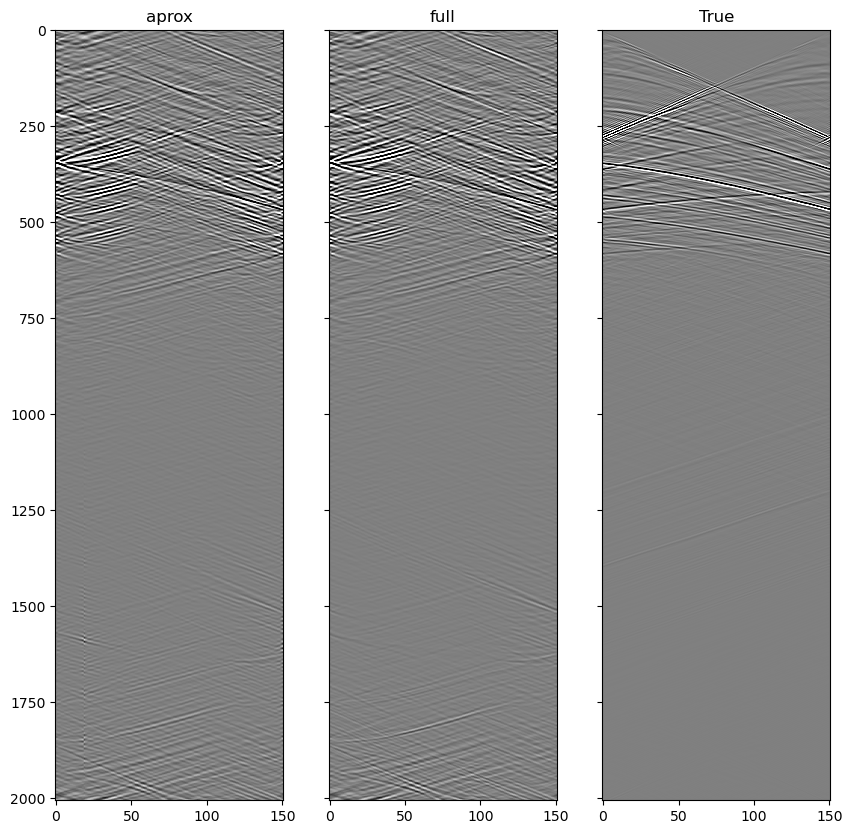


  virt = 100



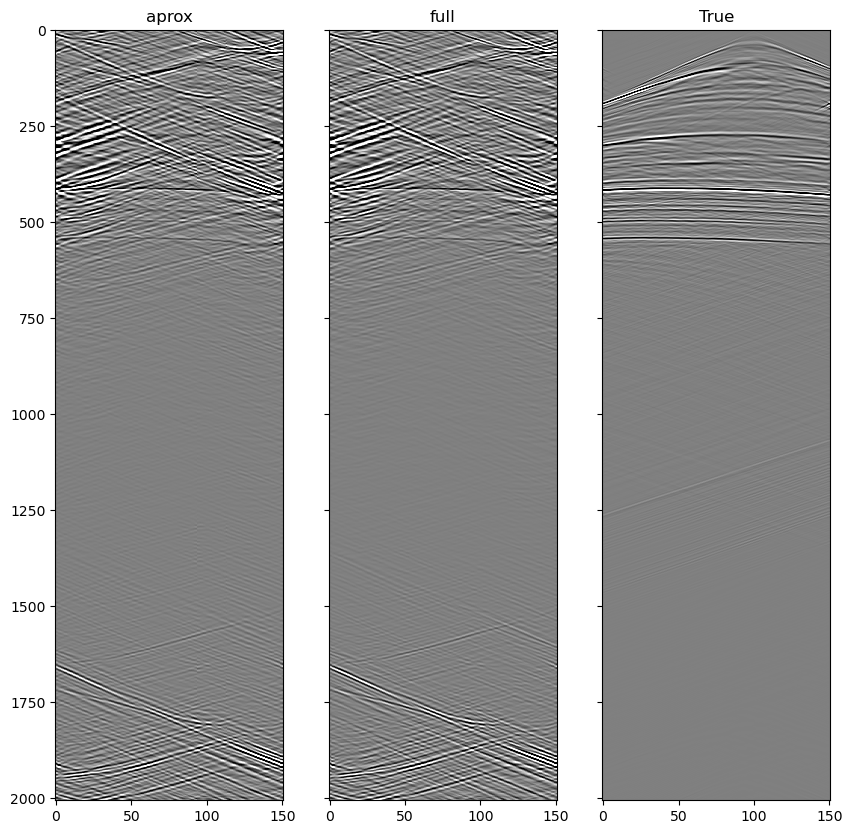

In [57]:
clip = 0.07
for iv in range(0, nr, 100):
    print(f'\n  virt = {iv}\n')
    fig, axs = plt.subplots(1, 3, sharey=True, figsize=(10, 10))
    
    axs[0].imshow(x_sc_t[:,:,iv], cmap='gray', vmin=-clip*np.abs(x_sc_t).max(), vmax=clip*np.abs(x_sc_t).max())
    axs[0].set_title(f'aprox')
    axs[0].axis('tight')
    
    
    axs[1].imshow(x_full_t[:,:,iv], cmap='gray', vmin=-clip*np.abs(x_sc_t).max(), vmax=clip*np.abs(x_sc_t).max())
    axs[1].set_title(f'full')
    axs[1].axis('tight')
    
    axs[2].imshow(x_true_t[:,:,iv], cmap='gray', vmin=-clip*np.abs(x_true_t).max(), vmax=clip*np.abs(x_true_t).max())
    axs[2].set_title(f'True')
    axs[2].axis('tight')
    
    plt.show()

### symmetry

In [23]:
class Recop(object):
    def __init__(self, geom, rks_c, b_size, disp = 0):
        self.geom = geom
        self.r = rks_c
        self.b_size = b_size
        self.disp = disp
    def __call__(self,  vec):
        t0 = time()
        tmp = 0
        ans = np.array([])
        for i in range(nfmax):
            n = self.b_size[i]
            sc = vec_to_sc(self.geom, self.geom, vec[tmp:tmp+n], self.r, self.r)
            ans = np.concatenate((ans, 0.5*(sc.to_vec + sc.T.to_vec)))
            tmp = tmp + n
        if self.disp:
            print(f"Matvec time:{time() - t0}, helm: {helm}")
        return ans

In [24]:
matvec  = Recop(geom_c, w_full[0].rks_c, b_size_cc)
rmatvec = Recop(geom_c, w_full[0].rks_c, b_size_cc)
rcp_lo  = LinearOperator((n_cc, n_cc), matvec=matvec, rmatvec=rmatvec)
lo_sym  = mm_lo * rcp_lo

Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!


Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!


In [25]:
### dot test (passed)
np.random.seed(0)
u_vec = np.random.rand(n_cc)
# print(np.linalg.norm(u_vec))
# np.random.seed(1)
v_vec = np.random.rand(n_cc)
# print(np.linalg.norm(v_vec))

test0 = v_vec.T.conj()@(rcp_lo.matvec(u_vec))
test1 = (rcp_lo.rmatvec(v_vec)).T.conj() @ u_vec

np.linalg.norm(test0 - test1)/ np.linalg.norm(test0)

Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!


Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!


Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!


2.7546735558629306e-16

In [26]:
### dot test (passed)
np.random.seed(0)
u_vec = np.random.rand(n_cc)
# print(np.linalg.norm(u_vec))
# np.random.seed(1)
v_vec = np.random.rand(n_rc)
# print(np.linalg.norm(v_vec))

test0 = v_vec.T.conj()@(lo_sym.matvec(u_vec))
test1 = (lo_sym.rmatvec(v_vec)).T.conj() @ u_vec

np.linalg.norm(test0 - test1)/ np.linalg.norm(test0)

Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!


Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!


Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!


1.8923629814945318e-15

In [27]:
t0 = time()
ans = lsqr(lo_sym, b_full, damp=1e-10, iter_lim=iter_lim, show=1)[0]
print(f"Time: {time()-t0} sec")

 
LSQR            Least-squares solution of  Ax = b
The matrix A has 3757600 rows and 3380400 columns
damp = 1.00000000000000e-10   calc_var =        0
atol = 1.00e-06                 conlim = 1.00e+08
btol = 1.00e-06               iter_lim =       20
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing

Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!


Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!


Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!


Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!


Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!


Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!


Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!


Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!


Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!


Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!


Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!


Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!


Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!


Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!


Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!


Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!


Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!


Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!


Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!


Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!


Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!


Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!


Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!


Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!


Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!


Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!


Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!


Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!


Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!


Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!


Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!


Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!


Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!


Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!


Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!


Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!


Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!


Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!


Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!


Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!


Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!


Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!


Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!


Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!


Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!


Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!


Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!
Warning! Re-vectorizing!


In [28]:
x_sc_s_fr = np.zeros((nfmax,nr,nr),dtype=complex)
tmp = 0
for i_fr in range(nfmax):
    print(i_fr)
    x_sc = vec_to_sc(geom_c, geom_c, ans[tmp:tmp + b_size_cc[i_fr]], w_full[i_fr].rks_r, w_full[i_fr].rks_r)
    tmp = tmp + b_size_cc[i_fr]
    v = v_full[i_fr]
    x_sc_s_fr[i_fr, :, :] = suv_to_mat(x_sc, v.T.conj, v.conj)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [30]:
x_sc_s_t = ((FopXf.H @ (IopXf.H @ x_sc_s_fr.ravel())).real).reshape(ntpad, nr, nv)


  virt = 0



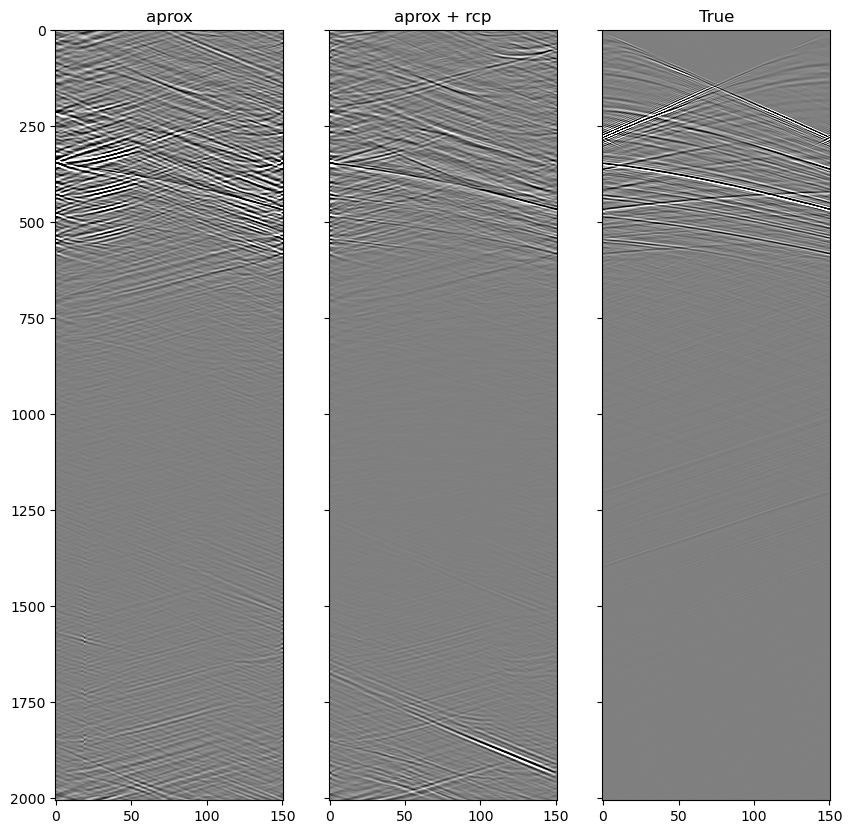


  virt = 50



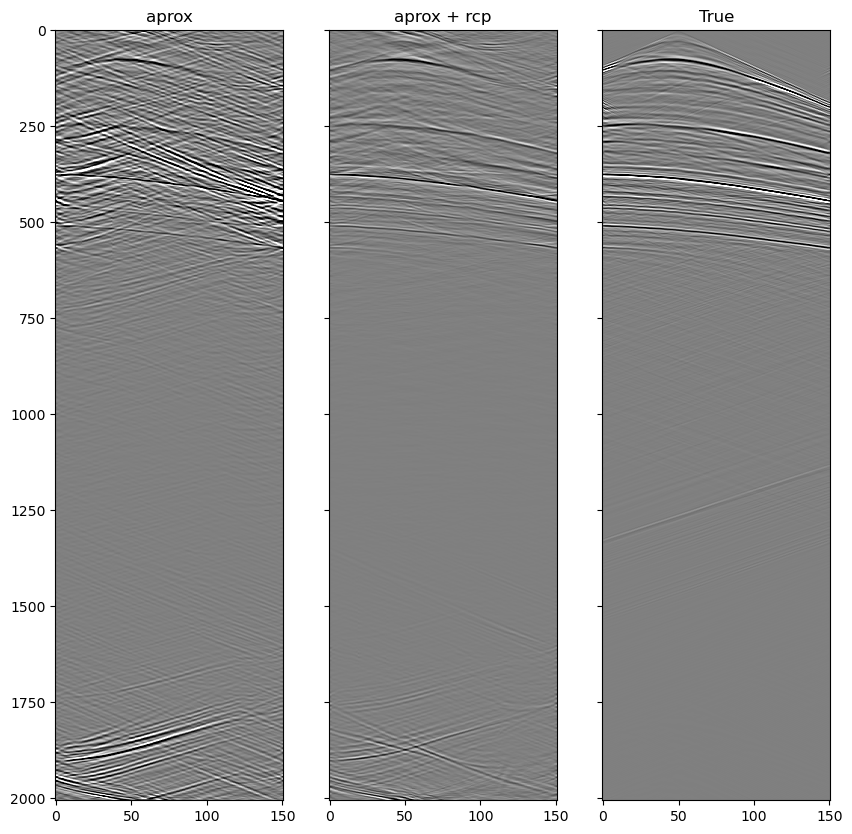


  virt = 100



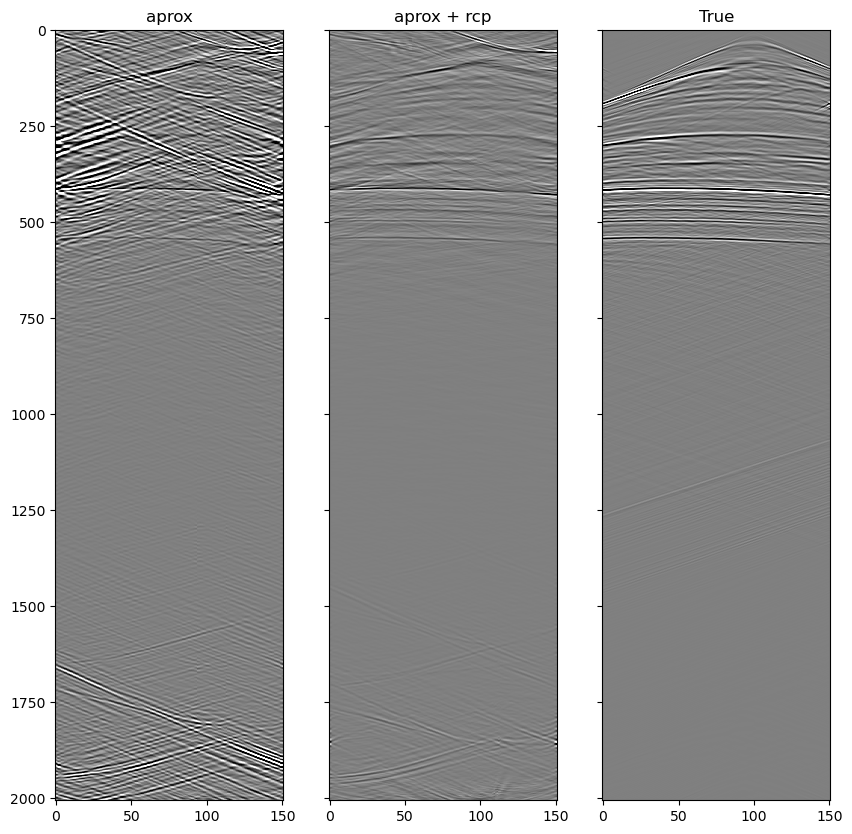


  virt = 150



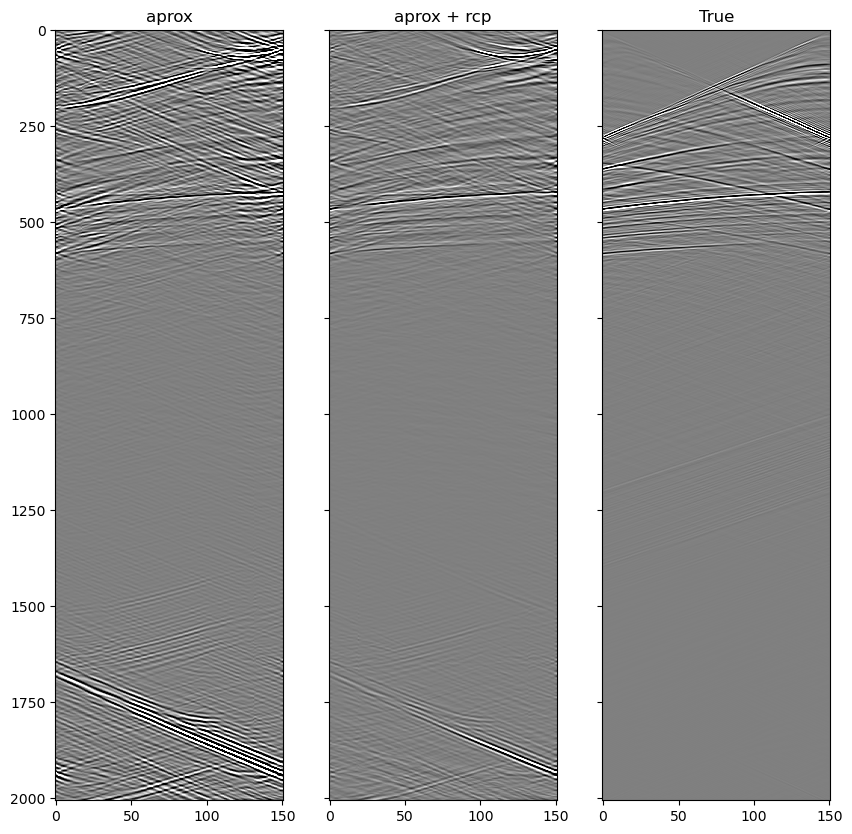

In [31]:
clip = 0.07
for iv in range(0, nr, 50):
    print(f'\n  virt = {iv}\n')
    fig, axs = plt.subplots(1, 3, sharey=True, figsize=(10, 10))
    
    axs[0].imshow(x_sc_t[:,:,iv], cmap='gray', vmin=-clip*np.abs(x_sc_t).max(), vmax=clip*np.abs(x_sc_t).max())
    axs[0].set_title(f'aprox')
    axs[0].axis('tight')
    
    
    axs[1].imshow(x_sc_s_t[:,:,iv], cmap='gray', vmin=-clip*np.abs(x_sc_t).max(), vmax=clip*np.abs(x_sc_t).max())
    axs[1].set_title(f'aprox + rcp')
    axs[1].axis('tight')
    
    axs[2].imshow(x_true_t[:,:,iv], cmap='gray', vmin=-clip*np.abs(x_true_t).max(), vmax=clip*np.abs(x_true_t).max())
    axs[2].set_title(f'True')
    axs[2].axis('tight')
    
    plt.show()

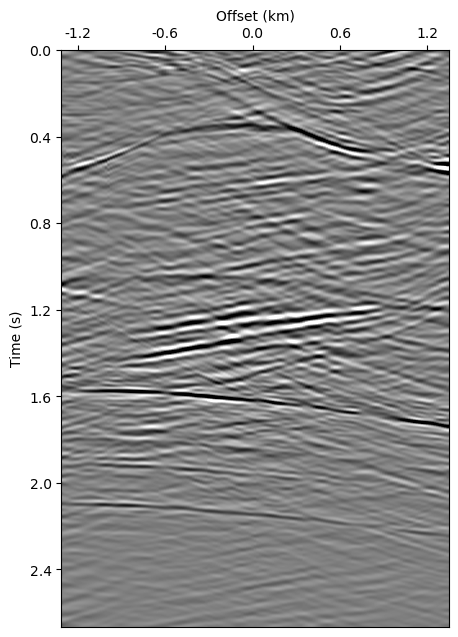

In [29]:
#h2
from matplotlib import ticker

clip = 0.4
iv = 100

x = x_sc_t[:nt//3, nr//2]
fig, ax = plt.subplots(1, 1, sharey=True, figsize=(5, 7.5))    
ax.imshow(x, cmap='gray', vmin=-clip*np.abs(x).max(), vmax=clip*np.abs(x).max())
ax.set_ylabel('Time (s)')
ax.set_xlabel(f'Offset (km)')
ax.xaxis.set_label_position('top')

positions = np.arange(6,nr,34)
labels = np.arange(-1.2, 1.3, 0.6)
labels = [round(x,1) for x in labels]
ax.xaxis.set_major_locator(ticker.FixedLocator(positions))
ax.xaxis.set_major_formatter(ticker.FixedFormatter(labels))

positions = np.arange(0,7500,100)
labels = np.arange(0, 10, 0.4)
labels = [round(x,1) for x in labels]
ax.yaxis.set_major_locator(ticker.FixedLocator(positions))
ax.yaxis.set_major_formatter(ticker.FixedFormatter(labels))

ax.tick_params(top=True, labeltop=True, bottom=False, labelbottom=False)
ax.axis('tight')

fig.savefig('../figs/paper/ds2_h2.png')

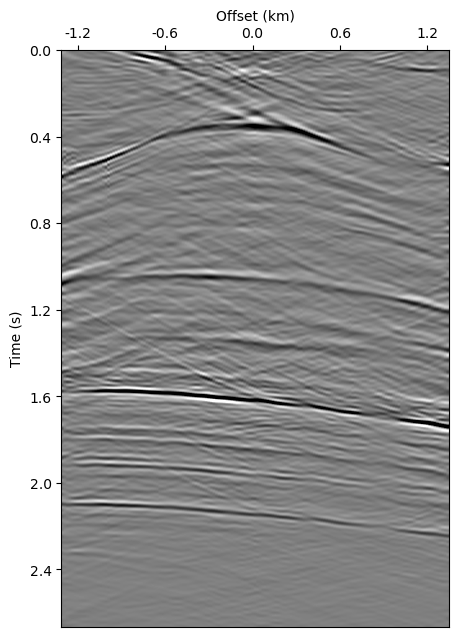

In [32]:
#h2 - sym
from matplotlib import ticker

clip = 0.4
iv = 100

x = x_sc_s_t[:nt//3, nr//2]
fig, ax = plt.subplots(1, 1, sharey=True, figsize=(5, 7.5))    
ax.imshow(x, cmap='gray', vmin=-clip*np.abs(x).max(), vmax=clip*np.abs(x).max())
ax.set_ylabel('Time (s)')
ax.set_xlabel(f'Offset (km)')
ax.xaxis.set_label_position('top')

positions = np.arange(6,nr,34)
labels = np.arange(-1.2, 1.3, 0.6)
labels = [round(x,1) for x in labels]
ax.xaxis.set_major_locator(ticker.FixedLocator(positions))
ax.xaxis.set_major_formatter(ticker.FixedFormatter(labels))

positions = np.arange(0,7500,100)
labels = np.arange(0, 10, 0.4)
labels = [round(x,1) for x in labels]
ax.yaxis.set_major_locator(ticker.FixedLocator(positions))
ax.yaxis.set_major_formatter(ticker.FixedFormatter(labels))

ax.tick_params(top=True, labeltop=True, bottom=False, labelbottom=False)
ax.axis('tight')

fig.savefig('../figs/paper/ds2_h2-sym.png')